# Homework 3: Visualizing Data with Movies

Name: 

Date: 

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [1]:
# import modules here
import netCDF4 as nc4
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
import moviepy.video.io.ImageSequenceClip
import cftime
import calendar


## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [2]:
# define the path to the data folder
data_folder = 'C:\\Users\\andre\\Desktop\\Classwork\\cs185c\\data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [3]:
# read in the data
sst_data = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SST','SST_20150101.nc')

ds = xr.open_dataset(sst_data, decode_times=False)


longitude = np.array(ds['LONGITUDE_T'][:])
longitude
latitude = np.array(ds['LATITUDE_T'][:])
sst = np.array(ds['SST'][:])
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (TIME: 1, LATITUDE_T: 720, LONGITUDE_T: 1440)
Coordinates:
  * TIME         (TIME) float32 4B 8.402e+03
  * LATITUDE_T   (LATITUDE_T) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * LONGITUDE_T  (LONGITUDE_T) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    SST          (TIME, LATITUDE_T, LONGITUDE_T) float32 4MB ...
Attributes:
    description:  ECCO LLC270 daily average

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [4]:
# define the longitude/latitude bounds
min_lon = -90.375
max_lon = 0.375
min_lat = 0.375
max_lat = 60.375

# compute the min/max row/col in the data grid

min_row = np.where(longitude == min_lon)[0][0]
max_row = np.where(longitude == max_lon)[0][0]

min_col = np.where(latitude == min_lat)[0][0]
max_col = np.where(latitude == max_lat)[0][0]



Use the row and column bounds to subset the longitude, latitude, and your variable:

In [5]:
# subset the data
lon_subset = longitude[min_row:max_row]
lat_subset = latitude[min_col:max_col]

sst_full = sst[0,:,:]
sst_subset = sst[0, min_col:max_col, min_row:max_row]
#sst_subset = np.nan_to_num(sst_subset, nan=0.0)
print(sst_subset.shape, lon_subset.shape, lat_subset.shape)
sst_subset


(240, 363) (363,) (240,)


array([[25.3338   , 25.413986 , 25.470316 , ..., 26.934656 , 26.979818 ,
        27.027308 ],
       [25.654219 , 25.728056 , 25.784811 , ..., 27.268324 , 27.315142 ,
        27.363146 ],
       [25.957615 , 26.025967 , 26.083057 , ..., 27.59759  , 27.643017 ,
        27.68882  ],
       ...,
       [-1.7688901, -1.7758019, -1.7823288, ...,  8.664726 ,  8.615788 ,
         8.553872 ],
       [-1.7801118, -1.7831374, -1.7870067, ...,  8.757203 ,  8.75256  ,
         8.706425 ],
       [-1.7840335, -1.7854646, -1.7885077, ...,  8.766235 ,  8.836895 ,
         8.885798 ]], dtype=float32)

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

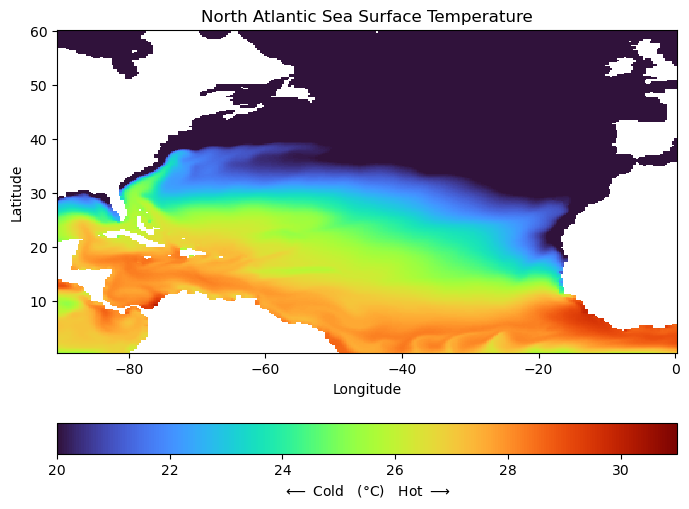

In [6]:
# make your figure here
fig = plt.figure(figsize=(8, 6))

# plot the temperature
# plt.pcolormesh(longitude, latitude, sst_full
#                , vmin=20, vmax=31, cmap='turbo', shading='auto')
#Y,X=np.meshgrid(lat_subset, lon_subset)
plt.pcolormesh(lon_subset, lat_subset, sst_subset
                , vmin=20, vmax=31, cmap='turbo', shading='auto')
plt.colorbar(orientation='horizontal',
             label='$\longleftarrow$ Cold   ($\degree$C)   Hot $\longrightarrow$' )
# format the axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North Atlantic Sea Surface Temperature')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [7]:
def plot_panel(year,month,day):
    # load data
    yr = str(year)
    mo = '{:02d}'.format(month)
    da = '{:02d}'.format(day)
    file_name = 'SST'+'_'+yr+''+mo+''+da
    sst_data = os.path.join(data_folder,'ECCO','Version5','Alpha',
                          'latlon_daily','SST',file_name+'.nc')

    # read data
    ds = xr.open_dataset(sst_data, decode_times=False)
    longitude = np.array(ds['LONGITUDE_T'][:])
    longitude
    latitude = np.array(ds['LATITUDE_T'][:])
    sst = np.array(ds['SST'][:])

    # define the longitude/latitude bounds
    min_lon = -90.375
    max_lon = 0.375
    min_lat = 0.375
    max_lat = 60.375
    
    # compute the min/max row/col in the data grid
    min_row = np.where(longitude == min_lon)[0][0]
    max_row = np.where(longitude == max_lon)[0][0]
    
    min_col = np.where(latitude == min_lat)[0][0]
    max_col = np.where(latitude == max_lat)[0][0]

    # subset the data
    lon_subset = longitude[min_row:max_row]
    lat_subset = latitude[min_col:max_col]
    sst_subset = sst[0, min_col:max_col, min_row:max_row]

    # plot data
    fig = plt.figure(figsize=(8, 6))
    plt.pcolormesh(lon_subset, lat_subset, sst_subset
                    , vmin=20, vmax=31, cmap='turbo', shading='auto')
    plt.colorbar(orientation='horizontal',
                 label='$\longleftarrow$ Cold   ($\degree$C)   Hot $\longrightarrow$' )
    
    # format the axes
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('North Atlantic Sea Surface Temperature')

    file_path = os.path.join('.\\frames',file_name+'.png')

    plt.savefig(file_path)
    plt.close(fig)
    
plot_panel(2015,1,1)

        

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [8]:
# loop through the data and make a plot for each day
year = 2015
# for month in range(1,13):
#     if month in [1,3,5,7,8,10,12]:
#         n_days = 31
#     elif month in [4,6,9,11]:
#         n_days = 30
#     else:
#         if year%4==0:
#             n_days = 29
#         else:
#             n_days = 28
#     for day in range(1,n_days+1):
#         plot_panel(year,month,day)

for month in range(1,13):
    for day in range(1, calendar.monthrange(year,month)[1]):
        plot_panel(year,month,day)
            

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [9]:
# make a list of files for each movie panel
image_files = []
for month in range(1,13):
    for day in range(1, calendar.monthrange(year,month)[1]):
        yr = str(year)
        mo = '{:02d}'.format(month)
        da = '{:02d}'.format(day)
        file_name = 'SST'+'_'+yr+''+mo+''+da
        path = os.path.join('.\\frames', file_name+'.png')
        image_files.append(path)

#image_files


# sort the panels
image_files.sort



<function list.sort(*, key=None, reverse=False)>

In [12]:
# set the frames per second
fps = 15


# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps = fps)


# write the video to a file
clip.write_videofile('North Atlantic Sea Surface Temperature.mp4')

t:   1%|▍                                                                    | 2/353 [00:18<53:45,  9.19s/it, now=None]

Moviepy - Building video North Atlantic Sea Surface Temperature.mp4.
Moviepy - Writing video North Atlantic Sea Surface Temperature.mp4




t:   1%|▍                                                                  | 2/353 [00:22<1:05:19, 11.17s/it, now=None]

Moviepy - Done !
Moviepy - video ready North Atlantic Sea Surface Temperature.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer:
The movie generated visualizes the sea surface temperature over the North Atlantic Ocean. In this movie, you can see the effects of the North Atlantic Gyre that moves water in a clockwise direction. Throughout the course of the year, warm water from the equator is transported west-northward and concentrates in the gulf of Mexico. As the year progresses, the warm water spreads over to the U.S. East Coast. During this process, water from the northern east coast travels eastward towards Europe and Africa, cooling down greatly. Once water reaches the coasts of Africa, it begins to move towards the equator to heat up once again. 

During the warmer months, the warmer water rises higher in latitude (up to 40N) but in the colder months, the warmer water stays low (only up to 30N).